# 3D Gaussian Splatting with 3DGUT Tutorial

This notebook demonstrates the NVIDIA 3DGUT (3D Gaussian with Unscented Transforms) workflow for rendering real-world scenes in interactive simulation.

Based on: https://developer.nvidia.com/blog/how-to-instantly-render-real-world-scenes-in-interactive-simulation/

## Workflow Steps:
1. Environment verification
2. Dataset download (NeRF Synthetic Lego)
3. Training with 3DGUT
4. Visualization
5. Export to USD format for Isaac Sim

## 1. Environment Check and Setup

Verify that we're in the correct conda environment and have all necessary dependencies.

In [1]:
import sys
import os
import subprocess

# Check Python version
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Check if we're in the 3dgrut environment
conda_env = os.environ.get('CONDA_DEFAULT_ENV', 'unknown')
print(f"\nConda environment: {conda_env}")

if conda_env != '3dgrut':
    print("\n⚠️  WARNING: Not in 3dgrut conda environment!")
    print("Please run: conda activate 3dgrut")
    print("Then restart this notebook kernel.")
else:
    print("✓ Correct environment activated")

Python version: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
Python executable: /home/ubuntu/miniconda3/envs/3dgrut/bin/python

Conda environment: 3dgrut
✓ Correct environment activated


In [2]:
# Check CUDA availability
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print("✓ CUDA is ready")
    else:
        print("⚠️  WARNING: CUDA not available!")
except ImportError:
    print("⚠️  ERROR: PyTorch not installed!")
    print("Please ensure the 3dgrut environment is properly installed.")

PyTorch version: 2.1.2
CUDA available: True
CUDA version: 11.8
GPU: NVIDIA L40S
GPU memory: 47.69 GB
✓ CUDA is ready


In [3]:
# Set up paths
WORK_DIR = "/home/ubuntu"
REPO_DIR = os.path.join(WORK_DIR, "3dgrut")
DATA_DIR = os.path.join(WORK_DIR, "data")
OUTPUT_DIR = os.path.join(WORK_DIR, "runs")

# Change to repo directory
os.chdir(REPO_DIR)
print(f"Working directory: {os.getcwd()}")

# Create data and output directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Working directory: /home/ubuntu/3dgrut
Data directory: /home/ubuntu/data
Output directory: /home/ubuntu/runs


## 2. Dataset Download

Download the NeRF Synthetic Lego dataset. This is a small synthetic scene perfect for testing.

In [4]:
import urllib.request
import zipfile
import json
from pathlib import Path

# Dataset URL (using a mirror since the original might require authentication)
DATASET_URL = "https://huggingface.co/datasets/nerfbaselines/nerfbaselines-data/resolve/main/blender/lego.zip"
DATASET_NAME = "lego"
DATASET_PATH = os.path.join(DATA_DIR, "nerf_synthetic", DATASET_NAME)

def download_dataset():
    """Download and extract the NeRF Synthetic Lego dataset."""
    
    # Check if already downloaded
    if os.path.exists(DATASET_PATH) and os.path.exists(os.path.join(DATASET_PATH, "transforms_train.json")):
        print(f"✓ Dataset already exists at {DATASET_PATH}")
        return True
    
    print(f"Downloading dataset from {DATASET_URL}...")
    zip_path = os.path.join(DATA_DIR, "lego.zip")
    
    try:
        # Download
        urllib.request.urlretrieve(DATASET_URL, zip_path)
        print(f"✓ Downloaded to {zip_path}")
        
        # Extract
        print("Extracting...")
        os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(DATASET_PATH))
        
        # Clean up zip file
        os.remove(zip_path)
        print(f"✓ Dataset extracted to {DATASET_PATH}")
        return True
        
    except Exception as e:
        print(f"⚠️  Error downloading dataset: {e}")
        print("\nAlternative: Download manually from:")
        print("https://www.kaggle.com/datasets/nguyenhung1903/nerf-synthetic-dataset")
        print(f"Extract to: {DATASET_PATH}")
        return False

download_dataset()

✓ Downloaded to /home/ubuntu/data/lego.zip
Extracting...
✓ Dataset extracted to /home/ubuntu/data/nerf_synthetic/lego


True

In [5]:
# Verify dataset structure
def verify_dataset():
    """Check if dataset has the expected structure."""
    required_files = [
        "transforms_train.json",
        "transforms_test.json",
        "transforms_val.json"
    ]
    
    print("Checking dataset structure...")
    all_good = True
    
    for file in required_files:
        path = os.path.join(DATASET_PATH, file)
        if os.path.exists(path):
            print(f"✓ {file}")
        else:
            print(f"✗ {file} - MISSING")
            all_good = False
    
    # Check for images
    train_dir = os.path.join(DATASET_PATH, "train")
    if os.path.exists(train_dir):
        num_images = len([f for f in os.listdir(train_dir) if f.endswith('.png')])
        print(f"✓ Found {num_images} training images")
    else:
        print(f"✗ train/ directory - MISSING")
        all_good = False
    
    if all_good:
        print("\n✓ Dataset structure is valid!")
    else:
        print("\n⚠️  Dataset structure is incomplete!")
    
    return all_good

verify_dataset()

Checking dataset structure...
✓ transforms_train.json
✓ transforms_test.json
✓ transforms_val.json
✓ Found 100 training images

✓ Dataset structure is valid!


True

## 3. Training Configuration

Set up the training configuration for 3DGUT. We'll use the NeRF Synthetic config with options to export to USD format.

In [6]:
# Training parameters
CONFIG_NAME = "apps/nerf_synthetic_3dgut.yaml"
EXPERIMENT_NAME = "lego_3dgut_tutorial"
N_ITERATIONS = 30000  # Reduce to 1000 for quick testing
EXPORT_USD = True

print("Training Configuration:")
print(f"  Config: {CONFIG_NAME}")
print(f"  Dataset: {DATASET_PATH}")
print(f"  Output: {OUTPUT_DIR}/{EXPERIMENT_NAME}")
print(f"  Iterations: {N_ITERATIONS}")
print(f"  Export USD: {EXPORT_USD}")
print(f"\nEstimated training time: ~{N_ITERATIONS//1000 * 0.5:.1f} minutes (on L40S GPU)")

Training Configuration:
  Config: apps/nerf_synthetic_3dgut.yaml
  Dataset: /home/ubuntu/data/nerf_synthetic/lego
  Output: /home/ubuntu/runs/lego_3dgut_tutorial
  Iterations: 30000
  Export USD: True

Estimated training time: ~15.0 minutes (on L40S GPU)


## 4. Train with 3DGUT

Run the training process. This will:
1. Initialize 3D Gaussians from the dataset
2. Optimize Gaussian parameters using the 3DGUT method
3. Save checkpoints at iterations 7000 and 30000
4. Export to USD format (if enabled)

In [7]:
# Build the training command
train_cmd = [
    "python", "train.py",
    f"--config-name={CONFIG_NAME}",
    f"path={DATASET_PATH}",
    f"out_dir={OUTPUT_DIR}",
    f"experiment_name={EXPERIMENT_NAME}",
    f"n_iterations={N_ITERATIONS}",
]

if EXPORT_USD:
    train_cmd.extend([
        "export_usdz.enabled=true",
        "export_usdz.apply_normalizing_transform=true"
    ])

print("Training command:")
print(" ".join(train_cmd))
print("\nStarting training...\n")

Training command:
python train.py --config-name=apps/nerf_synthetic_3dgut.yaml path=/home/ubuntu/data/nerf_synthetic/lego out_dir=/home/ubuntu/runs experiment_name=lego_3dgut_tutorial n_iterations=30000 export_usdz.enabled=true export_usdz.apply_normalizing_transform=true

Starting training...



In [9]:
# Run training
# Note: This will take several minutes to complete
import subprocess

try:
    result = subprocess.run(
        train_cmd,
        cwd=REPO_DIR,
        capture_output=False,  # Show output in real-time
        text=True
    )
    
    if result.returncode == 0:
        print("\n✓ Training completed successfully!")
    else:
        print(f"\n⚠️  Training failed with exit code {result.returncode}")
        
except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user")
except Exception as e:
    print(f"\n⚠️  Error during training: {e}")

[01:44:51] [INFO] Git hash:                                         ]8;id=756294;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=769516;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
           a03c594e66e0900f3fb784d6c2c6b0e2518c70c7                             
           [INFO] Compiling native code..                           ]8;id=701594;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=775133;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
──────────────────────────────── Load Datasets ─────────────────────────────────
Load Dataset (train) ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% :: 🕒 Elapsed 0:00:00
Load Dataset (val) ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% :: 🕒 Elapsed 0:00:00


/home/ubuntu/miniconda3/envs/3dgrut/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


─────────────────────────────── Initialize Model ───────────────────────────────


Using /ephemeral/cache/torch_extensions/py311_cu118 as PyTorch extensions root...
Creating extension directory /ephemeral/cache/torch_extensions/py311_cu118/lib3dgut_cc...
Detected CUDA files, patching ldflags
Emitting ninja build file /ephemeral/cache/torch_extensions/py311_cu118/lib3dgut_cc/build.ninja...
Building extension module lib3dgut_cc...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/5] c++ -MMD -MF cudaBuffer.o.d -DTORCH_EXTENSION_NAME=lib3dgut_cc -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/ubuntu/miniconda3/envs/3dgrut/targets/x86_64-linux/include -I/home/ubuntu/3dgrut/threedgut_tracer/include -I/home/ubuntu/3dgrut/thirdparty/tiny-cuda-nn/include -I/home/ubuntu/3dgrut/thirdparty/tiny-cuda-nn/dependencies -I/home/ubuntu/3dgrut/thirdparty/tiny-cuda-nn/dependencies/fmt/include -I/ephemeral/cache/torch_extensions/py311_cu118/lib3dgut_cc -isystem /home/ubuntu/miniconda3/envs/3dgrut/lib/python3.11/site-packages/torch/include -isystem /home/ubuntu/miniconda3/envs/3dgrut/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/ubuntu/miniconda3/envs/3dgrut/lib/python3.11/site-packages/torch/include/TH -isystem /home/ubuntu/miniconda3/envs/3dgrut/lib/python3.11/site-packages/torch/include/THC -isystem /home/ubuntu/miniconda3/envs/3dgrut/include -i

Loading extension module lib3dgut_cc...


[5/5] c++ splatRaster.o gutRenderer.cuda.o cudaBuffer.o bindings.o -shared -L/home/ubuntu/miniconda3/envs/3dgrut/lib/stubs -L/home/ubuntu/miniconda3/envs/3dgrut/targets/x86_64-linux/lib -L/home/ubuntu/miniconda3/envs/3dgrut/targets/x86_64-linux/lib/stubs -lcuda -lnvrtc -L/home/ubuntu/miniconda3/envs/3dgrut/lib/python3.11/site-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/home/ubuntu/miniconda3/envs/3dgrut/lib -lcudart -o lib3dgut_cc.so
[01:45:25] [INFO] 🔆 Using GS strategy                              ]8;id=792914;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=793799;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
──────────────────────── Setup Model Weights & Training ────────────────────────


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 402MB/s] 


[01:45:28] [INFO] 🤸 Initiating new 3dgrut training..               ]8;id=795545;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=629320;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
           [INFO] Generating random point cloud (100000)...         ]8;id=388625;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=196075;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
           [INFO] 🔆 Using Adam optimizer                           ]8;id=551002;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=779310;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
           [INFO] 📊 Training logs & will be saved to:              ]8;id=277745;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=58123;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
           /home/ubuntu/runs/lego_3dgut_tutorial/lego-1702_0

2026-02-17 01:51:23,902 - threedgrut.export.usd_util - INFO - Creating USD file containing NuRec model
2026-02-17 01:51:23,915 - threedgrut.export.usd_util - INFO - Model bounding box: min=[-1.4295948 -1.3728889 -1.5056654], max=[1.3927971 1.4354897 1.0347366]
2026-02-17 01:51:23,973 - threedgrut.export.usd_util - INFO - USDZ file created successfully at /home/ubuntu/runs/lego_3dgut_tutorial/lego-1702_014528/export_last.usdz


[01:51:24] [INFO] 💾 Saved checkpoint to:                           ]8;id=589092;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=189760;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
           "/home/ubuntu/runs/lego_3dgut_tutorial/lego-1702_014528/             
           ckpt_last.pt"                                                        
──────────────────────────── Evaluation on Test Set ────────────────────────────
Load Dataset (test) ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% :: 🕒 Elapsed 0:00:00
[01:51:25] [INFO] Frame 0, PSNR: 34.161827087402344                 ]8;id=109603;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=509538;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py#67\67]8;;\
           [INFO] Frame 1, PSNR: 28.446258544921875                 ]8;id=621473;file:///home/ubuntu/3dgrut/threedgrut/utils/logger.py\logger.py]8;;\:]8;id=78826;file:///home/ubuntu/3dgrut/threedgrut/u

## 5. Check Training Results

Verify that training completed and checkpoints were saved.

Results in: /home/ubuntu/runs/lego_3dgut_tutorial/lego-1702_014528

00000.png:


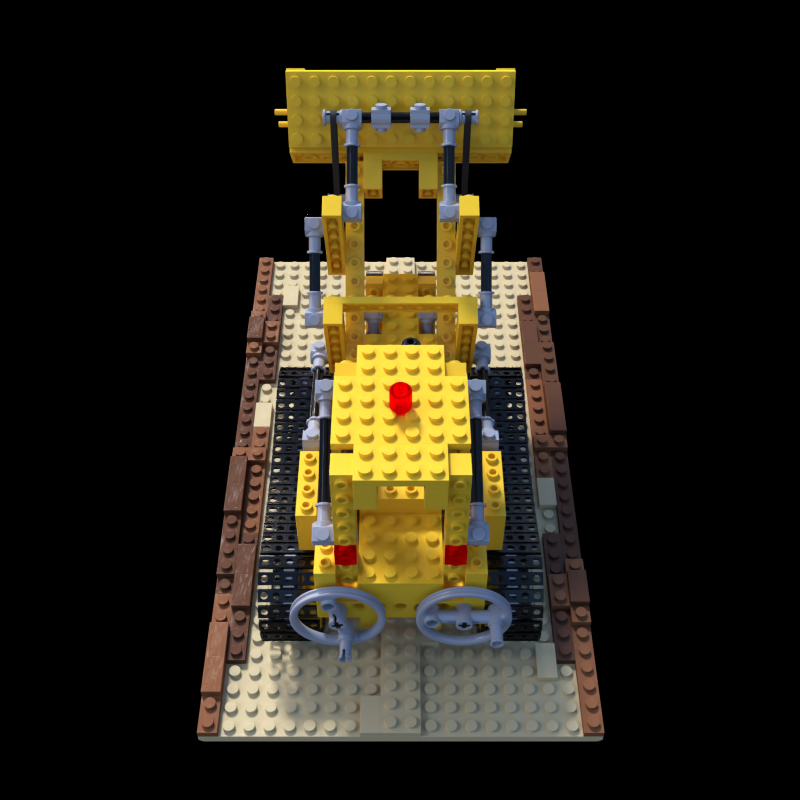

00001.png:


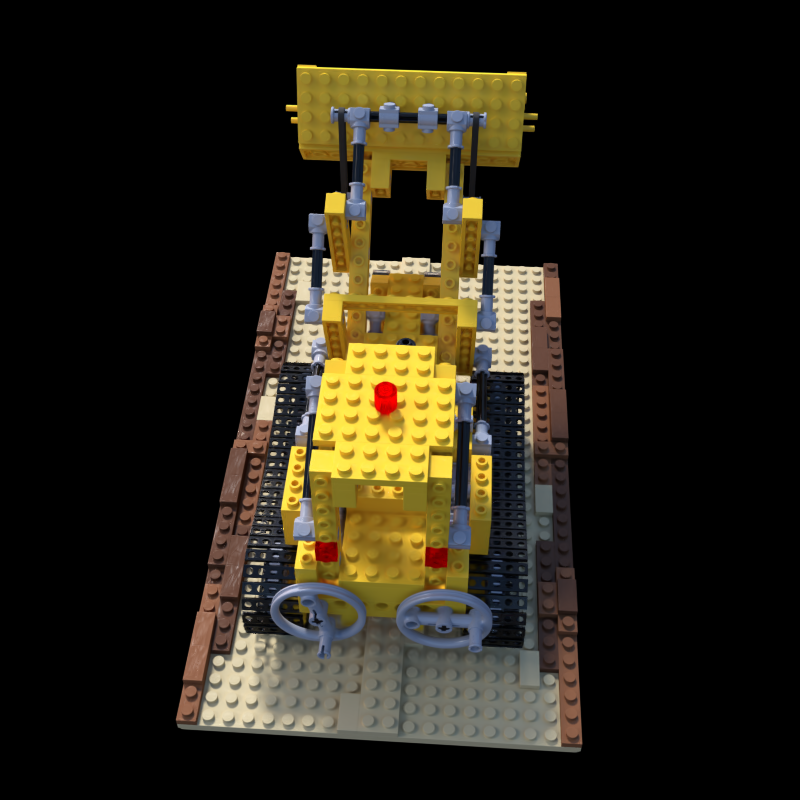

00002.png:


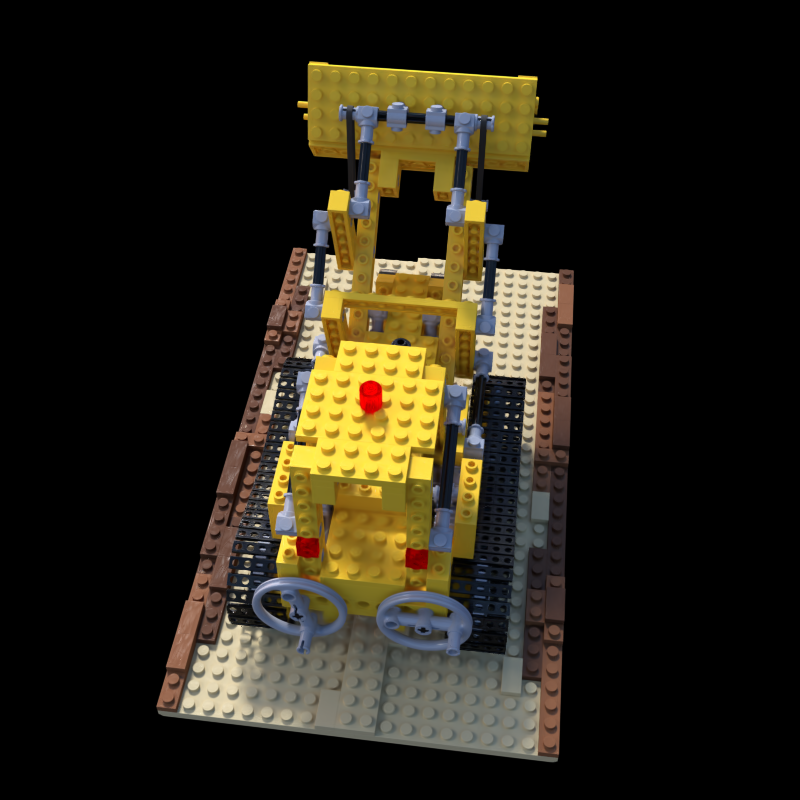

In [2]:
import glob
from IPython.display import Image, display

# Find the actual output directory
import os
base_dir = "/home/ubuntu/runs/lego_3dgut_tutorial"
subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
actual_dir = os.path.join(base_dir, subdirs[0])

print(f"Results in: {actual_dir}\n")

# Show rendered images
render_dir = os.path.join(actual_dir, "ours_30000/renders")
images = sorted(glob.glob(os.path.join(render_dir, "*.png")))[:3]

for img in images:
    print(f"{os.path.basename(img)}:")
    display(Image(filename=img, width=400))

In [3]:
# Create video from rendered images
import subprocess
from IPython.display import HTML
import base64

def create_video_from_renders(render_folder, output_path='lego_render.mp4', fps=10):
    """Create MP4 video from rendered images."""
    image_files = sorted(glob.glob(os.path.join(render_folder, '*.png')))
    
    if not image_files:
        print(f"⚠️  No images found in {render_folder}")
        return None
    
    print(f"Creating video from {len(image_files)} images at {fps} FPS...")
    
    # Create a temporary file list for ffmpeg
    list_file = '/tmp/image_list.txt'
    with open(list_file, 'w') as f:
        for img in image_files:
            f.write(f"file '{img}'\n")
            f.write(f"duration {1.0/fps}\n")
        f.write(f"file '{image_files[-1]}'\n")
    
    # Use ffmpeg to create video
    cmd = [
        'ffmpeg', '-y', '-f', 'concat', '-safe', '0',
        '-i', list_file, '-vf', 'fps=10',
        '-pix_fmt', 'yuv420p', output_path
    ]
    
    try:
        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✓ Video created: {output_path}")
            return output_path
        else:
            print(f"⚠️  ffmpeg error: {result.stderr}")
            return None
    except FileNotFoundError:
        print("⚠️  ffmpeg not found. Install with: sudo apt install ffmpeg")
        return None

def display_video(video_path):
    """Display video in notebook."""
    with open(video_path, 'rb') as f:
        video_data = f.read()
    video_base64 = base64.b64encode(video_data).decode('ascii')
    video_html = f'''
    <video width="800" controls loop>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    '''
    return HTML(video_html)

# Create and display video
video_path = create_video_from_renders(render_dir, fps=10)
if video_path:
    display(display_video(video_path))

Creating video from 200 images at 10 FPS...
✓ Video created: lego_render.mp4


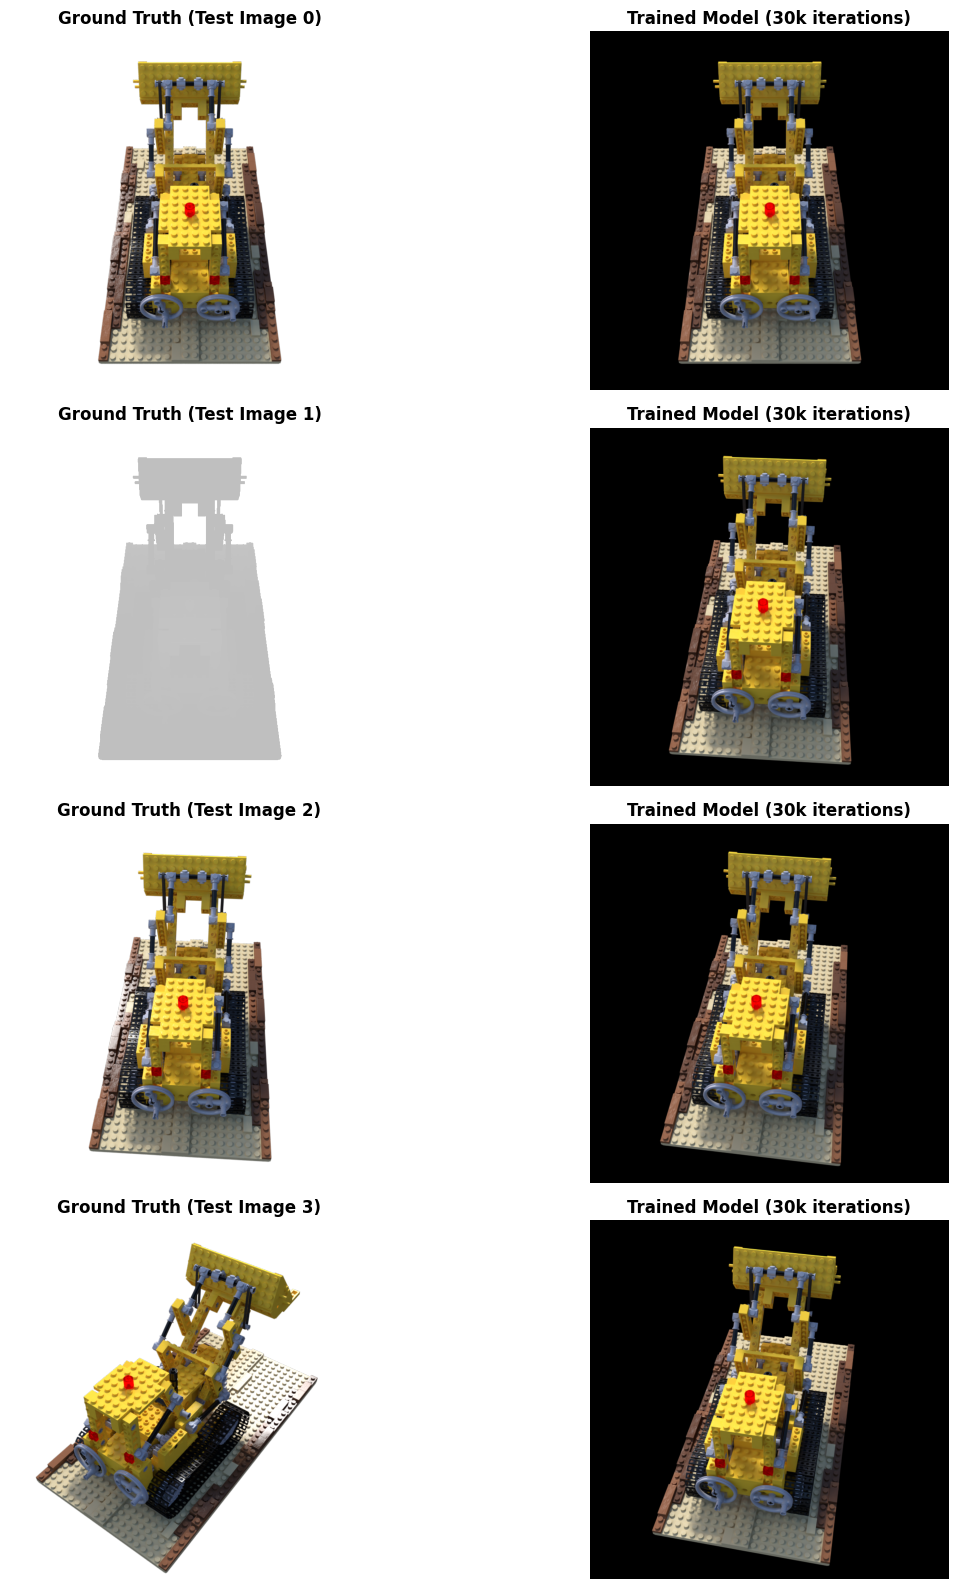

✓ Showing 4 before/after comparisons


In [4]:
# Before/After Training Comparison
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Find ground truth test images
dataset_path = '/home/ubuntu/data/nerf_synthetic/lego'
test_images = sorted(glob.glob(os.path.join(dataset_path, 'test', '*.png')))

# Find rendered images
rendered_images = sorted(glob.glob(os.path.join(render_dir, '*.png')))

if test_images and rendered_images:
    # Show 4 comparisons
    num_comparisons = min(4, len(test_images), len(rendered_images))
    
    fig, axes = plt.subplots(num_comparisons, 2, figsize=(14, 4*num_comparisons))
    if num_comparisons == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_comparisons):
        # Ground truth
        gt_img = PILImage.open(test_images[i])
        axes[i, 0].imshow(gt_img)
        axes[i, 0].set_title(f'Ground Truth (Test Image {i})', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Trained model output
        rendered_img = PILImage.open(rendered_images[i])
        axes[i, 1].imshow(rendered_img)
        axes[i, 1].set_title(f'Trained Model (30k iterations)', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Showing {num_comparisons} before/after comparisons")
else:
    print("⚠️  Could not find images")

In [6]:
# Check USD export for Isaac Sim
usd_files = glob.glob(os.path.join(actual_dir, '*.usdz')) + glob.glob(os.path.join(actual_dir, '*.usd'))

if usd_files:
    print("✓ USD files exported for Isaac Sim:\n")
    for usd_file in usd_files:
        file_size = os.path.getsize(usd_file) / (1024 * 1024)  # MB
        print(f"  📦 {os.path.basename(usd_file)}")
        print(f"     Size: {file_size:.2f} MB")
        print(f"     Path: {usd_file}\n")
    
    print("=" * 60)
    print("How to use in Isaac Sim:")
    print("=" * 60)
    print("1. Open NVIDIA Isaac Sim")
    print("2. File → Open or drag-and-drop the .usdz file")
    print("3. The 3D Gaussian Splatting scene will load")
    print("4. Add physics, robots, or other simulation elements")
    print("\nAlternatively, load programmatically:")
    print(f"```python")
    print(f"from pxr import Usd")
    print(f"stage = Usd.Stage.Open('{usd_files[0]}')")
    print(f"```")
else:
    print("⚠️  No USD files found")
    print("\nTo export USD, re-run training with:")
    print("export_usdz.enabled=true")

✓ USD files exported for Isaac Sim:

  📦 export_last.usdz
     Size: 27.76 MB
     Path: /home/ubuntu/runs/lego_3dgut_tutorial/lego-1702_014528/export_last.usdz

How to use in Isaac Sim:
1. Open NVIDIA Isaac Sim
2. File → Open or drag-and-drop the .usdz file
3. The 3D Gaussian Splatting scene will load
4. Add physics, robots, or other simulation elements

Alternatively, load programmatically:
```python
from pxr import Usd
stage = Usd.Stage.Open('/home/ubuntu/runs/lego_3dgut_tutorial/lego-1702_014528/export_last.usdz')
```
